In [1]:
import json
import seaborn as sns
from os.path import exists
import pandas as pd
import re

In [2]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 20,12

In [3]:
MODELS = [
    "text-davinci-002",
    "text-curie-001",
    "text-babbage-001",
    "bigscience/bloom",
    "EleutherAI/gpt-j-6B",
    "gpt-neox-20b",
    "facebook/opt-13b",
    "facebook/opt-30b",
    "co:here",
    "jurassic1-jumbo",
    "ul2",
    "google/flan-t5-xxl"
]

prompts = [
    "1",
    "2",
    "3",
    "4",
    "5",
]

n_shots = [1,3,5]

In [4]:
def array_to_prodigy(a):
    spans = []
    for i in range(len(a)):
        if a[i] != 'O':
            spans.append({
                "label": a[i],
                "start": i,
                "end": i+1
            })
    return spans

In [5]:
!pip install nervaluate

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [6]:
from datasets import load_dataset
dataset = load_dataset(
    "DFKI-SLT/few-nerd", "supervised", split=f"test[:100]"
)


FEW_NERD_ID2LABEL = {
    0: "O",
    1: "art",
    2: "building",
    3: "event",
    4: "location",
    5: "organization",
    6: "other",
    7: "person",
    8: "product",
}

Reusing dataset few-nerd (/home/daniel/.cache/huggingface/datasets/DFKI-SLT___few-nerd/supervised/0.0.0/e1ceeaee82073fea12206e4461c7cfcd67e68c8f3ebeca179bddcacee00c4511)


In [7]:
def find_e_in_dataset(e, prompt_template):
    t = e['prompt'][len(prompt_template):]
    for i in range(len(dataset)):
        dataset_text = " ".join(dataset[i]['tokens'])
        if t.find(dataset_text) >= 0:
            return dataset[i]


In [8]:
def get_tags_for_data_item(e, prompt_template):
    reg = re.compile(r'(\[([^\]]+)\]\(([^\(]*)\))')

    data_item = find_e_in_dataset(e, prompt_template)
    result = e['result']
    if result.find('\n') >= 0:
        result = result[:result.find('\n')]
    result = result.replace(',', ' ,')
    
    m = reg.findall(result)
    if m:
        for x in m:
            parsed = []
            for t in x[1].split(' '):
                parsed.append(f"{t}({x[2]})")
            result = result.replace(x[0], " ".join(parsed))
                
    tags = []
    for t in result.split(' '):
        if t:
            tags.append(t)
    
    for i in range(len(tags)):
        tags[i] = tags[i].strip()
        if tags[i].find("(") >= 0:
            tag = tags[i][tags[i].find("(") + 1 : -1]
            if tag in [
                "art",
                "building",
                "event",
                "location",
                "organization",
                "other",
                "person",
                "product",
            ]:
                tags[i] = tag
            else:
                tags[i] = "O"
        else:
            tags[i] = "O"
    
    return tags

In [9]:

from nervaluate import Evaluator

In [10]:
def calculate_nervaluate_metrics(data):
    true = []
    pred = []
    for p in data['data']:
        true.append(array_to_prodigy(p['label']))
        pred.append(array_to_prodigy(p['pred']))
    evaluator = Evaluator(true, pred, tags=["art", "building", "event", "location", "organization", "other", "person", "product"])

    results, results_per_tag = evaluator.evaluate()
    return results['strict']

In [11]:
log_data = []
for model in MODELS:
    for prompt in prompts:
        for n_shot in n_shots:
            prompt_name = prompt
            model_name = model.replace('/', '-')
            log_file = f"../llm_logs/ner-{model_name}-{prompt_name}-{n_shot}.json"
            if exists(log_file):
                with open(log_file) as f:
                    data = json.load(f)
                
                prompt_template = data['prompt_template']
                prompt_template = prompt_template[:prompt_template.rfind("{text}")]
                
                for i in range(len(data['data'])):
                    tags = get_tags_for_data_item(data['data'][i], prompt_template)
                    data['data'][i]['pred'] = tags
                
                metrics = calculate_nervaluate_metrics(data)
                    
                log_data.append({
                    "model": model,
                    "prompt": prompt_name,
                    "n_shot": n_shot,
                    "precision": metrics['precision'],
                    "recall": metrics['recall'],
                    "f1": metrics['f1']
                })
                
                data['metrics'] = metrics
                with open(log_file, 'w') as f:
                    json.dump(data, f, indent=4)
            print("n_shot", n_shot)
        print("prompt", prompt)
    print("model", model)


n_shot 1
n_shot 3
n_shot 5
prompt 1
n_shot 1
n_shot 3
n_shot 5
prompt 2
n_shot 1
n_shot 3
n_shot 5
prompt 3
n_shot 1
n_shot 3
n_shot 5
prompt 4
n_shot 1
n_shot 3
n_shot 5
prompt 5
model text-davinci-002
n_shot 1
n_shot 3
n_shot 5
prompt 1
n_shot 1
n_shot 3
n_shot 5
prompt 2
n_shot 1
n_shot 3
n_shot 5
prompt 3
n_shot 1
n_shot 3
n_shot 5
prompt 4
n_shot 1
n_shot 3
n_shot 5
prompt 5
model text-curie-001
n_shot 1
n_shot 3
n_shot 5
prompt 1
n_shot 1
n_shot 3
n_shot 5
prompt 2
n_shot 1
n_shot 3
n_shot 5
prompt 3
n_shot 1
n_shot 3
n_shot 5
prompt 4
n_shot 1
n_shot 3
n_shot 5
prompt 5
model text-babbage-001
n_shot 1
n_shot 3
n_shot 5
prompt 1
n_shot 1
n_shot 3
n_shot 5
prompt 2
n_shot 1
n_shot 3
n_shot 5
prompt 3
n_shot 1
n_shot 3
n_shot 5
prompt 4
n_shot 1
n_shot 3
n_shot 5
prompt 5
model bigscience/bloom
n_shot 1
n_shot 3
n_shot 5
prompt 1
n_shot 1
n_shot 3
n_shot 5
prompt 2
n_shot 1
n_shot 3
n_shot 5
prompt 3
n_shot 1
n_shot 3
n_shot 5
prompt 4
n_shot 1
n_shot 3
n_shot 5
prompt 5
model Eleu

In [12]:
model_map = [
    ("text-davinci-002","GPT3-davinci"),
    ("text-curie-001","GPT3-curie"),
    ("text-babbage-001","GPT3-babbage"),
    ("bigscience/bloom","BLOOM"),
    ("EleutherAI/gpt-j-6B","GPT-J-6B"),
    ("gpt-neox-20b","GPT-NeoX-20B"),
    ("facebook/opt-13b","OPT-13B"),
    ("facebook/opt-30b","OPT-30B"),
    ("co:here","Co:here"),
    ("jurassic1-jumbo","Jurassic-1 Jumbo"),
    ("ul2","UL2"),
    ("google/flan-t5-xxl","Flan-T5-xxl")
]
for m in model_map:
    for l in log_data:
        if l['model'] == m[0]:
            l['model'] = m[1]

In [13]:
df = pd.DataFrame(log_data)

In [14]:

pallete = ["#5cff85", "#52dfcd", "#6dc6ff", "#4c6ada", "#3849e0", "#7f38e0",
           "#c254dd", "#ef5151", "#a22f2f", "#ffbd3e", "#e5e72c", "#94ea40"]
customPalette = sns.set_palette(sns.color_palette(pallete))

In [15]:

rcParams['figure.figsize'] = 10,5
rcParams['figure.dpi'] = 200

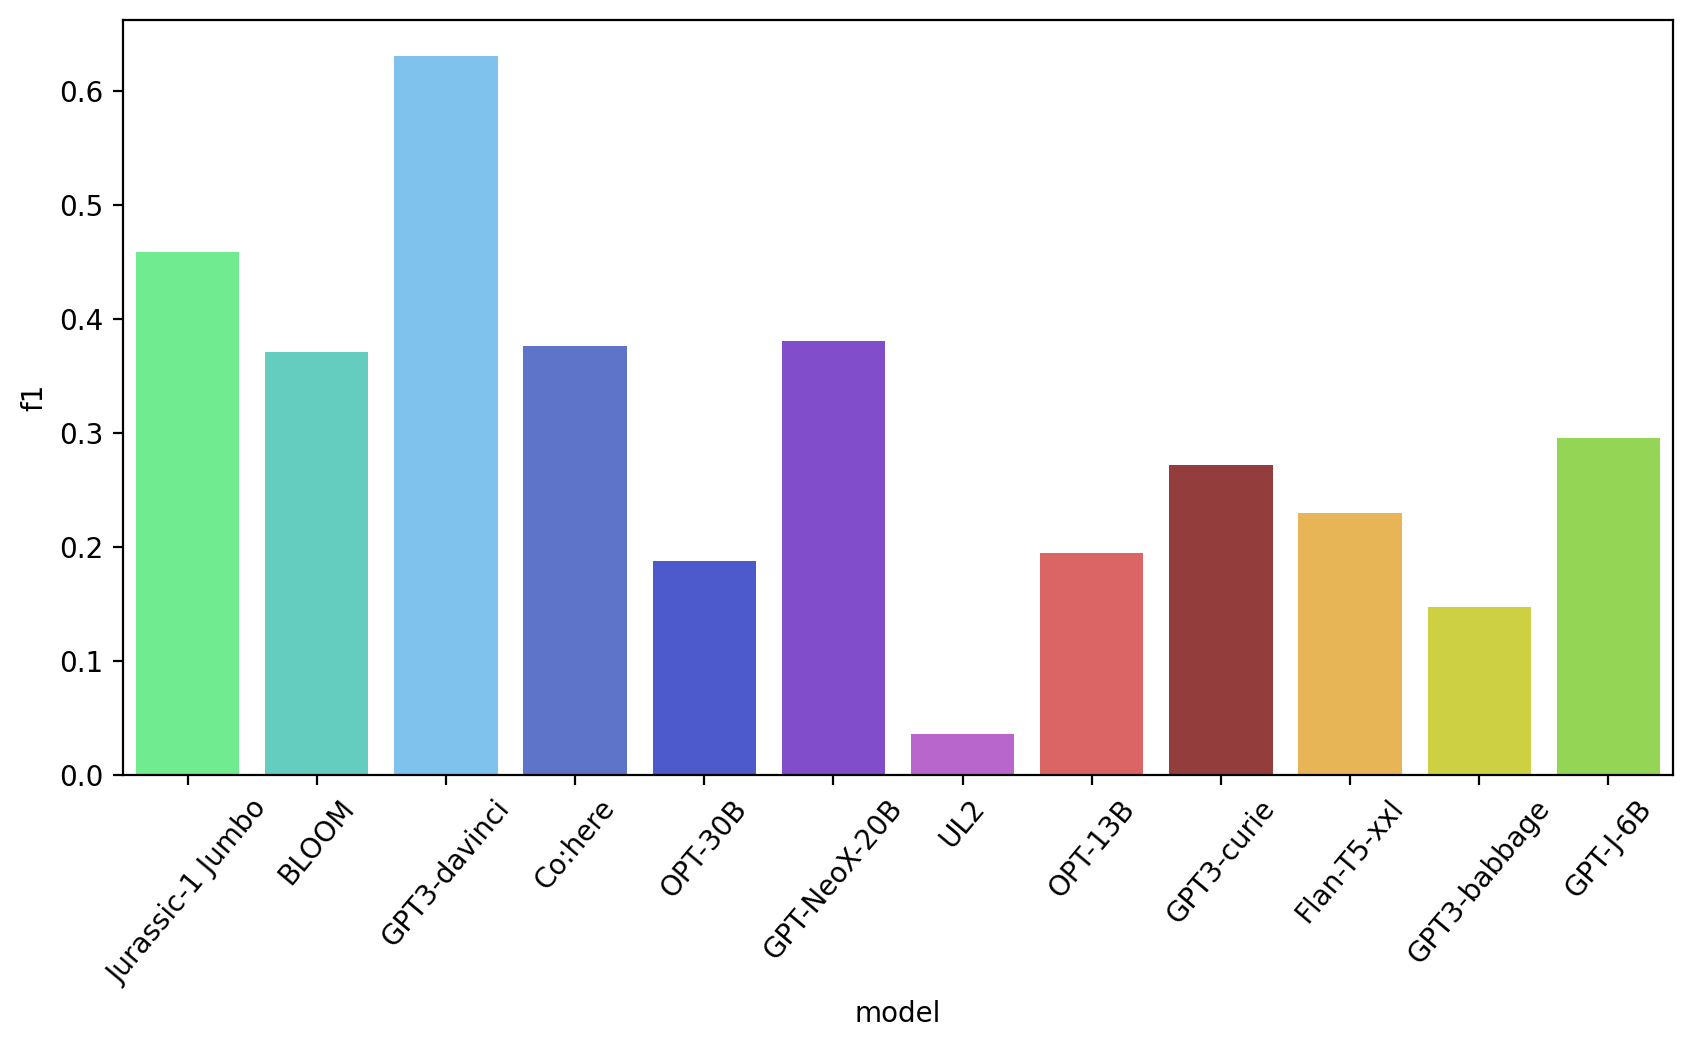

In [16]:



order = ["Jurassic-1 Jumbo", "BLOOM", "GPT3-davinci", "Co:here", "OPT-30B", 
         "GPT-NeoX-20B", "UL2", "OPT-13B", "GPT3-curie", "Flan-T5-xxl", "GPT3-babbage", "GPT-J-6B"]
df2 = df.loc[df['prompt'].isin(["1","2","3","4","5"])]
idx = df2.groupby(['model'])['f1'].transform(max) == df2['f1']
ax = sns.barplot(data=df2[idx], x="model", y="f1", palette=customPalette, order=order)
ax.tick_params(axis='x', rotation=50)

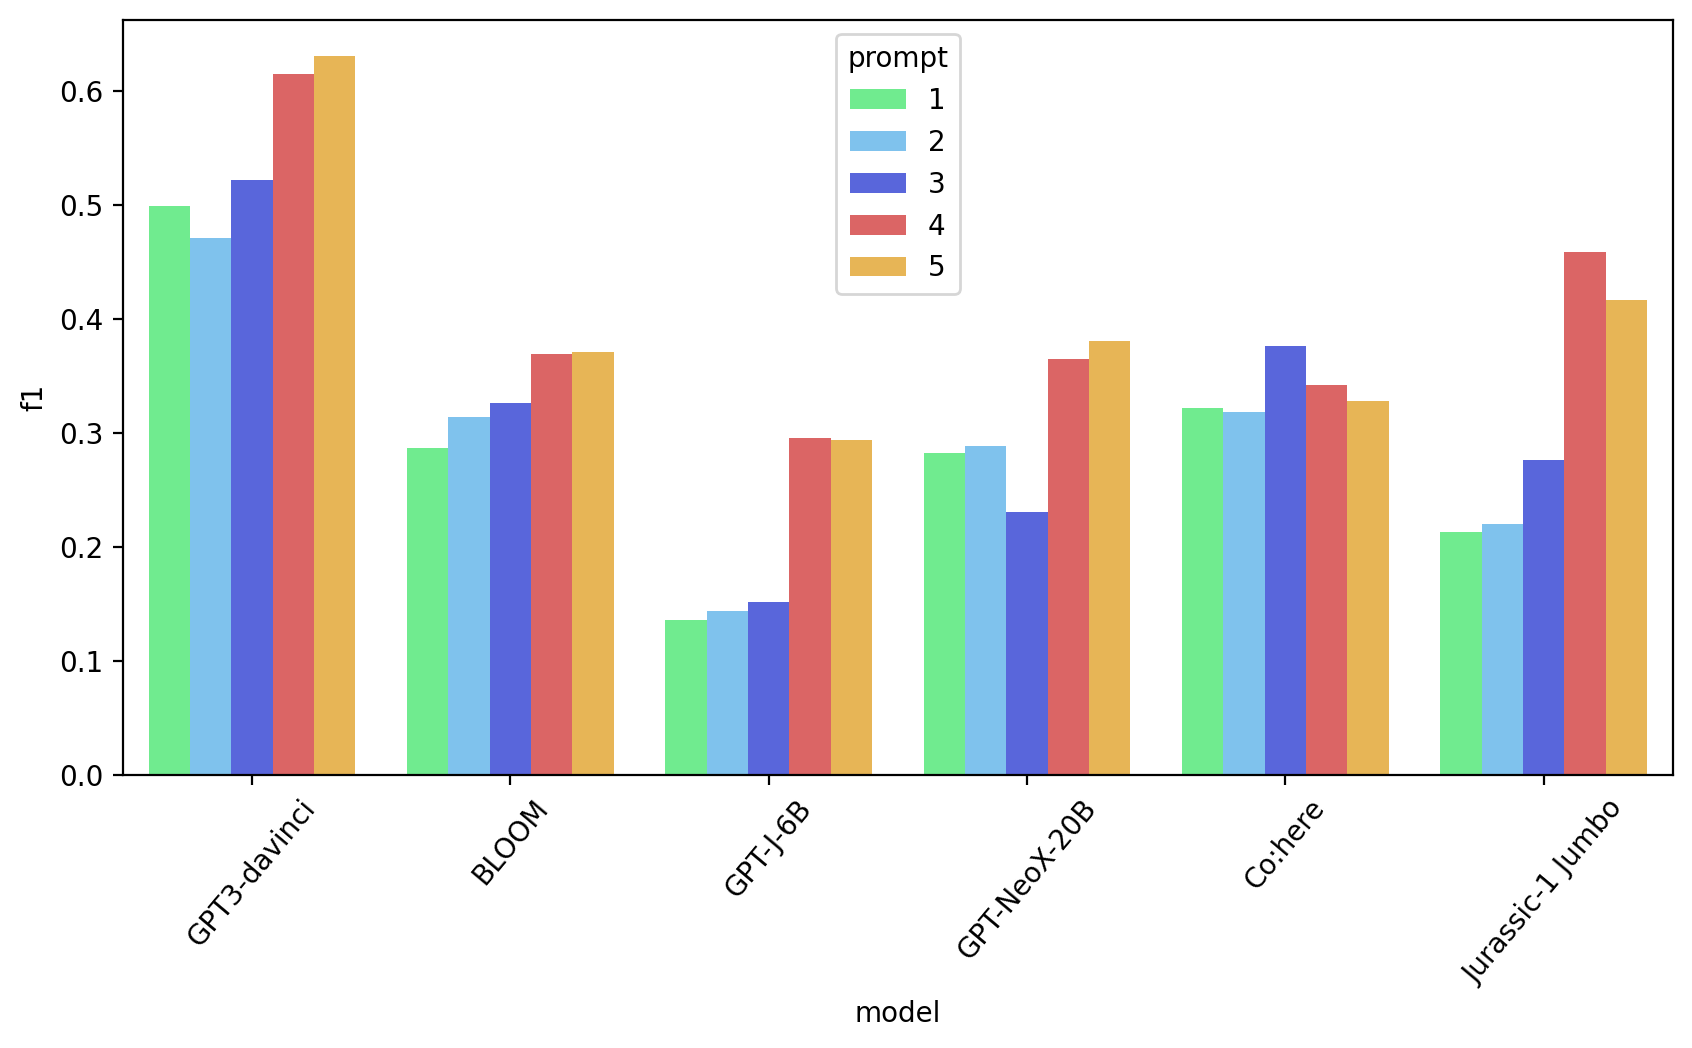

In [60]:
model_map = [
    ("text-davinci-002","GPT3-davinci"),
    ("text-curie-001","GPT3-curie"),
    ("text-babbage-001","GPT3-babbage"),
    ("bigscience/bloom","BLOOM"),
    ("EleutherAI/gpt-j-6B","GPT-J-6B"),
    ("gpt-neox-20b","GPT-NeoX-20B"),
    ("facebook/opt-13b","OPT-13B"),
    ("facebook/opt-30b","OPT-30B"),
    ("co:here","Co:here"),
    ("jurassic1-jumbo","Jurassic-1 Jumbo"),
    ("ul2","UL2"),
    ("google/flan-t5-xxl","Flan-T5-xxl")
]

pallete = ["#5cff85", "#6dc6ff", "#4455f0", "#ef5151", "#ffbd3e"]
customPalette = sns.set_palette(sns.color_palette(pallete))
df2 = df.loc[df['model'].isin(["GPT3-davinci", "BLOOM", "GPT-J-6B", "GPT-NeoX-20B", "Co:here",
                               "Jurassic-1 Jumbo"])]
df2 = df2.loc[df2['prompt'].isin(["1","2","3","4","5"])]
idx = df2.groupby(['model', 'prompt'])['f1'].transform(max) == df2['f1']
ax = sns.barplot(data=df2[idx], x="model", y="f1", hue="prompt", palette=customPalette)
ax.tick_params(axis='x', rotation=50)